In [1]:
import json
import numpy as np
import cv2
from scipy.optimize import minimize
from nvbts.calib import Cam2SensorCalib
from nvbts.markers import dome_3d

# from nvbts.objective import Cam2Sensor
calibration_file = '/home/hussain/calib_ws/src/aric-camera-calibration/calibration_data/long sensor/calibration_results.json'  # Change this to your calibration fil
calibrator = Cam2SensorCalib(calibration_file)

# Load the 3D markers
markers_3d = dome_3d()
calibrator.set_3d_markers(markers_3d)

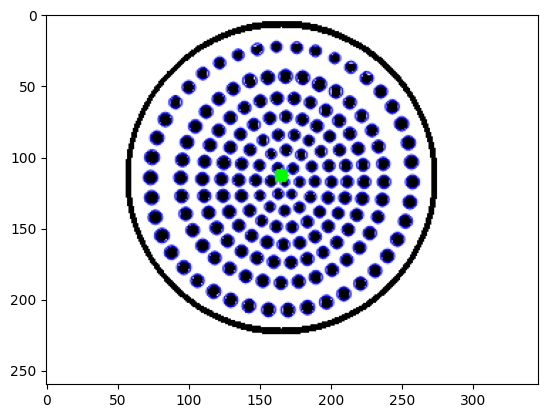

In [2]:
import matplotlib.pyplot as plt
from nvbts.markers import MarkerDetector

# Load the image
image = cv2.imread('/home/hussain/Desktop/final_resting.png')
md = MarkerDetector('nvbts/markers/blob.json', calibration_file)

# Detect the markers

img_with_markers, markers = md.apply(image, draw_keypoints=True)

# Draw the markers
plt.imshow(img_with_markers)

In [3]:
# from sklearn.cluster import KMeans

# k = 8

# markers_x = markers[:, 0]
# markers_y = markers[:, 1]
# marker_layers = []

# center_x = np.median(markers_x)
# center_y = np.median(markers_y)

# closest = np.argmin(np.sqrt((markers_x - center_x)**2 + (markers_y - center_y)**2))

# center_x, center_y = markers_x[closest], markers_y[closest]
# marker_layers.append(np.array([[center_x, center_y, 0, 0]]))

# #drop the center
# markers_xx = np.delete(markers_x, closest)
# markers_yy = np.delete(markers_y, closest)


# x = np.array(markers_xx) - center_x
# y = np.array(markers_yy) - center_y
# r = np.sqrt(x**2 + y**2)
# tan2_phi = np.arctan2(y, x)
# tan2_phi[tan2_phi < 0] += 2 * np.pi
# tan2_phi[tan2_phi > 2*np.pi] -= 2 * np.pi

# markers = np.array([markers_xx, markers_yy, r, tan2_phi]).T

# kmeans = KMeans(n_clusters=k, algorithm='lloyd', n_init='auto')

# kmeans.fit(r.reshape(-1, 1))
# labels = kmeans.labels_
# sorted_indices = np.argsort(kmeans.cluster_centers_.flatten())

# for i in range(k):
#     marker_layers.append(np.array(markers[labels == sorted_indices[i]]))
#     plt.scatter(marker_layers[i+1][:, 0], marker_layers[i+1][:, 1])

# x_coord = []
# y_coord = []
# la = []
# for layer, i in zip(marker_layers, range(len(marker_layers))):
#     if i == 0:
#         x_coord.append(layer[:,0].item())
#         y_coord.append(layer[:,1].item())
#         la.append(0)
#     else:
#         cluster_center = [np.median(layer[:,0]), np.median(layer[:,1])]
#         tan1_vec = np.arctan2(layer[:,1]-cluster_center[1], layer[:,0]-cluster_center[0])
#         right_marker = np.argmin(np.abs(tan1_vec))
#         x_coord.append(layer[right_marker,0].tolist())
#         y_coord.append(layer[right_marker,1].tolist())
#         la.append(i)
#         layer_tmp = np.delete(layer, right_marker, axis=0)
#         sorted_layer_indices = np.argsort(layer_tmp[:,3].flatten())
#         sorted_layer_indices = sorted_layer_indices[::-1]
#         for j in sorted_layer_indices:
#             x_tmp = layer_tmp[j,0]
#             y_tmp = layer_tmp[j,1]
#             x_coord.append(x_tmp)
#             y_coord.append(y_tmp)
#             la.append(i)


# sorted = np.stack((x_coord, y_coord), axis=-1)


In [9]:
from nvbts.markers import sort_markers_k_means

# markers_x, markers_y = markers[:, 0], markers[:, 1]

# Sort the markers
sorted, layer = sort_markers_k_means(markers, )

plt.figure(figsize=(10, 10))    
plt.imshow(image)

for i in range(len(markers[:, 0])):
    
    plt.text(sorted[:, 0][i], sorted[:, 1][i], str(i), fontsize=8, color='red')
    plt.scatter(sorted[:, 0][i], sorted[:, 1][i], color='red', s=10)


markers_exp = sorted

calibrator.set_2d_markers(markers_exp)

NameError: name 'k7' is not defined

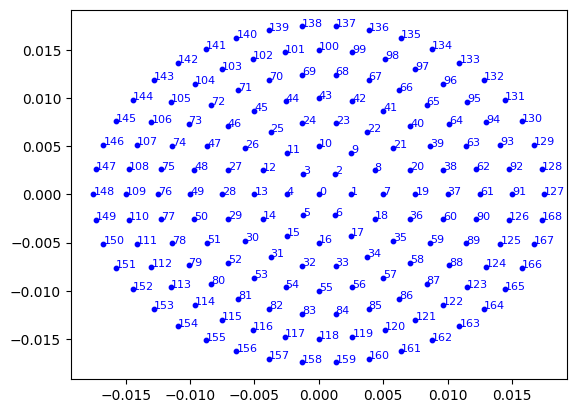

In [8]:
for i in range(len(markers_3d)):
    plt.text(markers_3d[i][0], markers_3d[i][1], str(i), fontsize=8, color='blue')
    plt.scatter(markers_3d[i][0], markers_3d[i][1], color='blue', s=10)

Reprojection error: 1.8707378028962547
Euler angles: [ 3.12858956  0.01736161 -3.11869199]
Translation: [ 0.00289232 -0.00165901 -0.04601728]


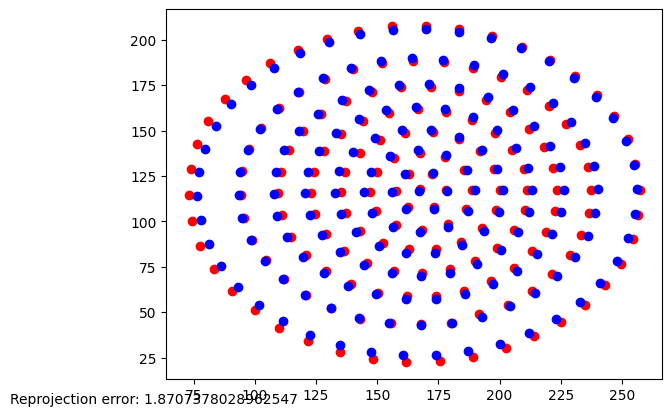

In [4]:
rvec, tvec = calibrator.calibrate()

In [5]:
from scipy.spatial.transform import Rotation as R

rpy = rvec#[ 3.12858956,  0.01736161, -3.11869199]
trans = tvec#[ 0.00289232, -0.00165901, -0.04601728]
Rmat = R.from_euler('xyz', rpy).as_matrix()
# Rmat = R.from_rotvec(rpy).as_matrix()

c2w = np.eye(4)
c2w[:3, :3] = Rmat
c2w[:3, 3] = tvec

calibrator._intrinsics['camera_matrix']

c2w

array([[-0.99958712, -0.0231224 ,  0.01705697,  0.00289232],
       [-0.02289521,  0.99964811,  0.01339682, -0.00165901],
       [-0.01736074,  0.01300077, -0.99976476, -0.04601728],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

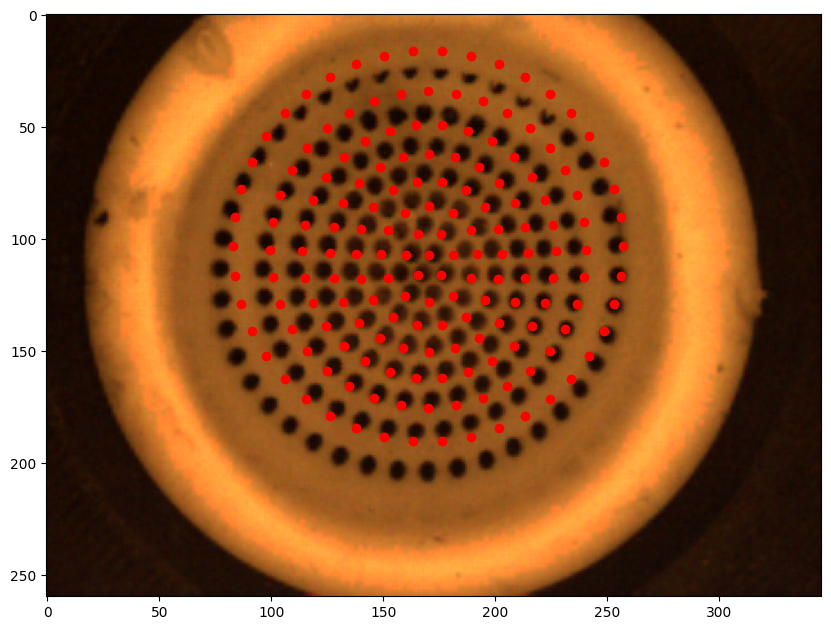

In [34]:
camera_matrix = np.array(calibrator._intrinsics['camera_matrix'])

xyz_world = dome_3d()
xyz_world =  np.c_[xyz_world, np.ones(xyz_world.shape[0])]

xyz_cam = np.linalg.inv(c2w) @ xyz_world.T
xyz_cam = xyz_cam[:3, :].T

u = xyz_cam[:, 0] / xyz_cam[:, 2] * camera_matrix[0, 0] + camera_matrix[0, 2]
v = xyz_cam[:, 1] / xyz_cam[:, 2] * camera_matrix[1, 1] + camera_matrix[1, 2]

plt.figure(figsize=(10, 10))
plt.scatter(u, v, color='red')
plt.imshow(image)


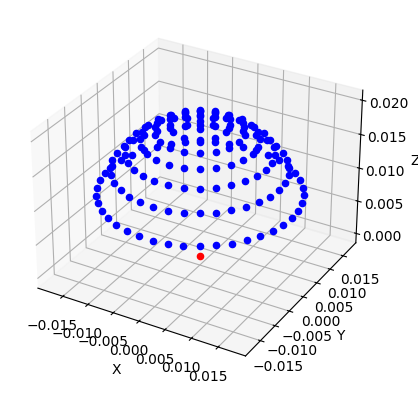

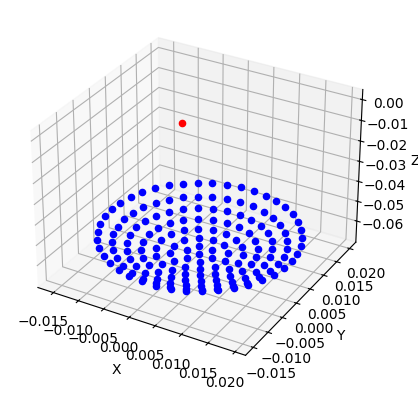

In [7]:
#make 3d ax

# Draw the 3D markers
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Draw the 3D markers
for marker in calibrator._3d_markers_arr:
    ax.scatter(marker[0], marker[1], marker[2], c='b', marker='o')

ax.scatter(0, 0, 0, c='r', marker='o')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Draw the 3D markers
for marker in xyz_cam:
    ax.scatter(marker[0], marker[1], marker[2], c='b', marker='o')

ax.scatter(0, 0, 0, c='r', marker='o')

# calibrator._3d_markers_arr

In [8]:
from scipy.spatial.transform import Rotation as R

r = R.from_euler('xyz', rvec)
rmat  = r.as_matrix()

transfrom = np.eye(4)
transfrom[:3, :3] = rmat
transfrom[:, 3] = np.array([tvec[0], tvec[1], tvec[2], 1])

transfrom

array([[-0.99958712, -0.0231224 ,  0.01705697,  0.00289232],
       [-0.02289521,  0.99964811,  0.01339682, -0.00165901],
       [-0.01736074,  0.01300077, -0.99976476, -0.04601728],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [9]:
calibrator.calibrate(method='matlab')

Calibration data saved to calib.mat. Run the matlab script to get the calibration data


In [10]:
init_cond = [0, 0, 0, 0, 0, 0]
bnds = np.array([(-0.1, 0.1), (-0.1, 0.1), (-2, 2), (-1, 1), (-1, 1), (-1, 1)])
bnds[3:] = bnds[3:] * np.pi / 180

print(bnds)
from nvbts.calib.objective import Cam2Sensor
from scipy.optimize import minimize

cam2sensor = Cam2Sensor(camera_matrix, calibrator._2d_markers_arr, calibrator._3d_markers_arr)

res = minimize(cam2sensor.obj, init_cond, bounds=bnds)
res

[[-0.1         0.1       ]
 [-0.1         0.1       ]
 [-2.          2.        ]
 [-0.01745329  0.01745329]
 [-0.01745329  0.01745329]
 [-0.01745329  0.01745329]]


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 4256.828180400475
        x: [-5.669e-02 -8.138e-02  2.000e+00 -1.745e-02 -1.745e-02
            -1.745e-02]
      nit: 13
      jac: [ 2.728e-04  0.000e+00 -4.334e+00  8.049e+00  6.386e-01
             8.603e-01]
     nfev: 140
     njev: 20
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>

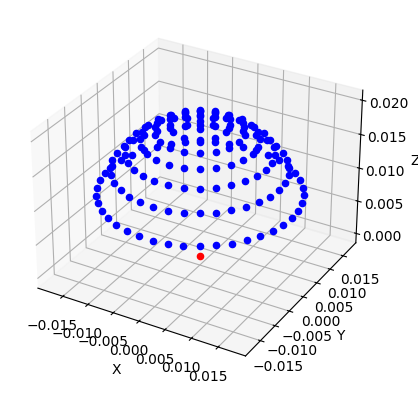

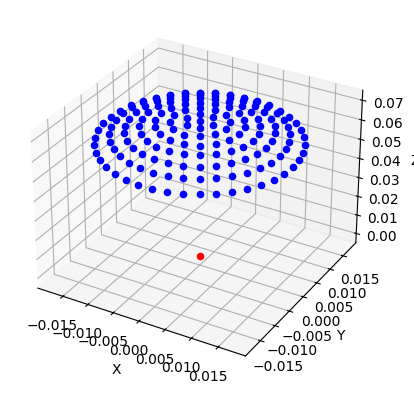

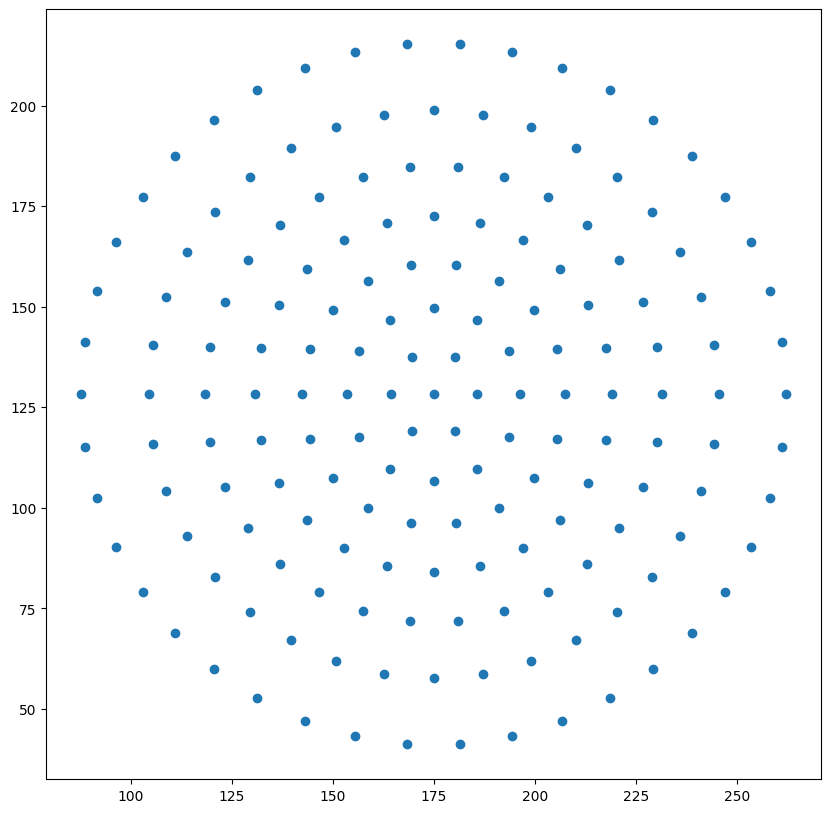

In [13]:


xyz_cam = np.linalg.inv(c2w) @ xyz_world.T
xyz_cam = xyz_cam[:3, :].T

rpy = res.x[3:]#[ 3.12858956,  0.01736161, -3.11869199]
trans = res.x[:3]#[ 0.00289232, -0.00165901, -0.04601728]
Rmat = R.from_euler('xyz', rpy).as_matrix()

c2w = np.eye(4)
c2w[:3, :3] = Rmat
c2w[:3, 3] = tvec

# Draw the 3D markers
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Draw the 3D markers
for marker in calibrator._3d_markers_arr:
    ax.scatter(marker[0], marker[1], marker[2], c='b', marker='o')

ax.scatter(0, 0, 0, c='r', marker='o')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')



# Draw the 3D markers
for marker in xyz_cam:
    ax.scatter(marker[0], marker[1], marker[2], c='b', marker='o')

ax.scatter(0, 0, 0, c='r', marker='o')

# calibrator._3d_markers_arr

plt.figure(figsize=(10, 10))
plt.scatter(u, v)

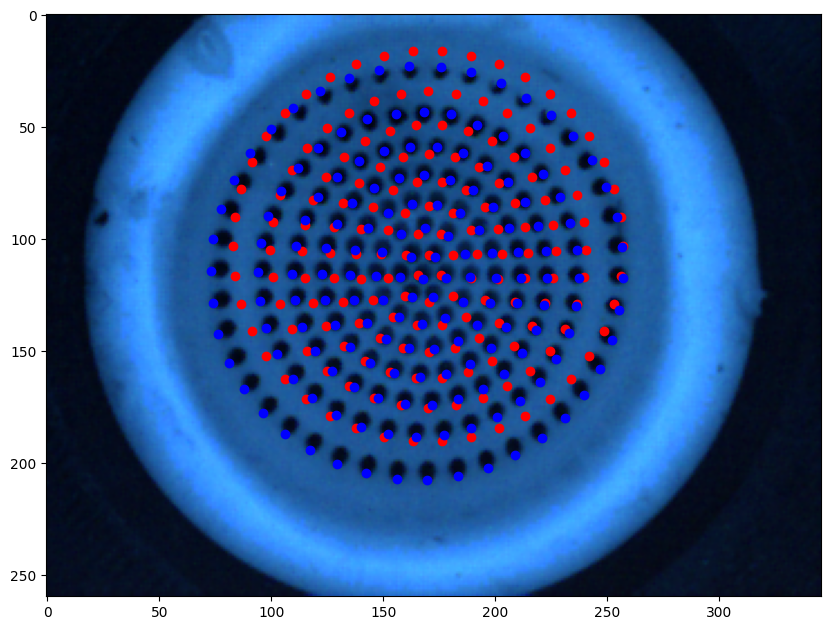

In [31]:
t = np.array([0.001, 0.005, -0.05])
r = np.array([0, 0, 0])

Rmat = R.from_euler('xyz', r).as_matrix()

c2w = np.eye(4)
c2w[:3, :3] = Rmat
c2w[:3, 3] = t

xyz_cam = np.linalg.inv(c2w) @ xyz_world.T
xyz_cam = xyz_cam[:3, :].T

u = xyz_cam[:, 0] / xyz_cam[:, 2] * camera_matrix[0, 0] + camera_matrix[0, 2]
v = xyz_cam[:, 1] / xyz_cam[:, 2] * camera_matrix[1, 1] + camera_matrix[1, 2]

uv = np.c_[u, v]

plt.figure(figsize=(10, 10))
plt.scatter(u, v, c='r')
plt.scatter(markers_exp[:, 0], markers_exp[:, 1], c='b')
plt.imshow(image)

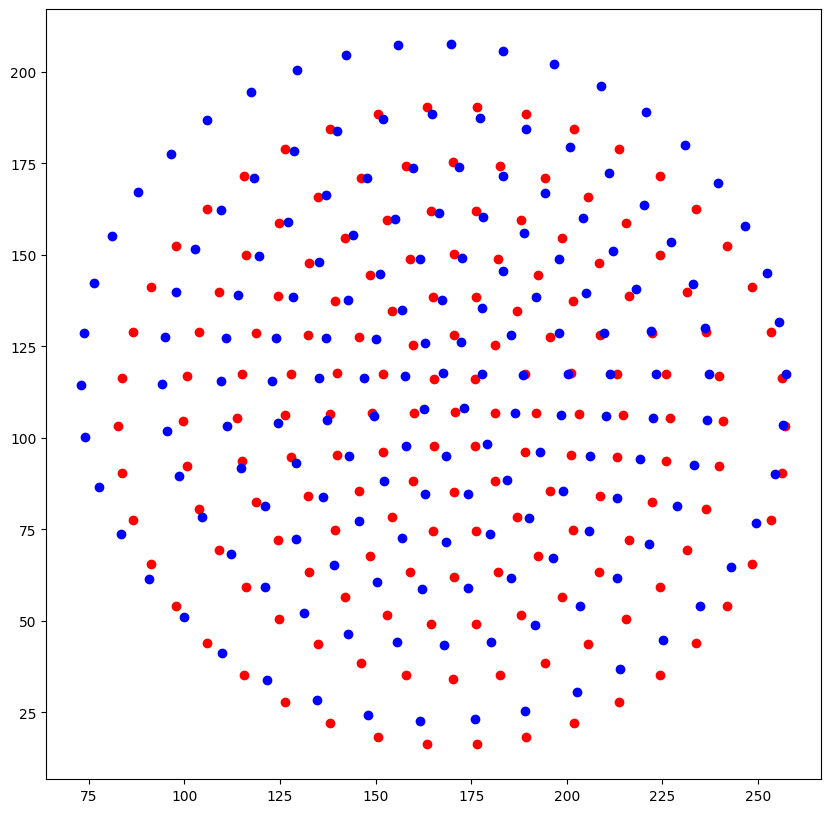

In [28]:
plt.figure(figsize=(10, 10))

plt.scatter(u, v, c='r')
plt.scatter(markers_exp[:, 0], markers_exp[:, 1], c='b')

In [26]:
(np.c_[u, v] - markers_exp)

array([[ 3.07342247e+00, -1.06786120e+01],
       [ 3.38356050e+00, -1.05767502e+01],
       [ 2.74200073e+00,  8.04375396e+00],
       [ 2.71464900e+00,  8.28610168e+00],
       [ 2.31697045e+00, -9.97447055e+00],
       [ 2.47621516e+00, -2.82384455e+01],
       [ 3.72195068e+00, -2.84113505e+01],
       [ 3.43854841e+00, -1.03801488e+01],
       [ 2.73515888e+00,  1.07853390e+01],
       [ 2.28765423e+00,  2.69034451e+01],
       [ 2.18638164e+00,  3.30824339e+01],
       [ 2.05863505e+00,  2.75253781e+01],
       [ 2.43824832e+00,  1.16461483e+01],
       [ 2.18601541e+00, -9.59999739e+00],
       [ 2.03532473e+00, -3.10456365e+01],
       [ 2.90711527e+00, -4.68078161e+01],
       [ 3.25323039e+00, -5.24326896e+01],
       [ 3.58959515e+00, -4.72534643e+01],
       [ 3.68936726e+00, -3.20428518e+01],
       [ 2.83782498e+00, -1.09879919e+01],
       [ 2.65204085e+00,  1.14731680e+01],
       [ 2.57939078e+00,  3.13520730e+01],
       [ 2.48075003e+00,  4.62832641e+01],
       [ 2.